<a href="https://colab.research.google.com/github/yagoluucas/Aprendizado-N-o-Supervisionado/blob/main/exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas necessárias

# Download do dataset

Para fazer o download do dataset basta entrar neste link e clicar na opção de download
https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [15]:
# importar as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando o algoritmo K-Means:
from sklearn.cluster import KMeans

# Métrica de avaliação para modelos de clustering:
from sklearn.metrics import silhouette_score

# O pacote warnings inibe a visualização de avisos nos outputs do Colab.
import warnings
warnings.filterwarnings('ignore')

# importando a fórmula que transforma object em tipo número e para normalização dos dados
from sklearn.preprocessing import LabelEncoder, StandardScaler

# importando o PCA para reduzir os números de atributos
from sklearn.decomposition import PCA


# Parte 1: Redução de dimensionalidade com PCA

Vamos ler o nosso arquivo CSV, usando o parametro sep para indicar que a separação dos itens é por ponto e vírgula

In [16]:
# carregando dataframe
df = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


As colunas "Date" e "Time" são colunas irrelevantes para o nosso cenário. Por este motivo, vamos retirar essas colunas, passando o parâmetro axis=1, indicando que vamos remover a coluna

In [17]:
# tirando as colunas que não são necessárias
df = df.drop(columns=['Date', 'Time'], axis = 1)

Iniciando o tratamento dos nossos dados

* Primeiro uso a função isna junto com a sum para ver a quantidade de dados que são vazios/NaN

* Segundo, após a análise acima consegui verificar que existem dados faltantas, troco todos os dados que tem o campo igual a '?' por dados nan e após isso tiro todos eles do dataset

* Por fim, transformo todos os dados do meu dataset para o tipo float e uso a função info para verificar se foi corrigido

In [18]:
# contando a quantidade de nulos
df.isna().sum()

# tirando os dados vazios
df = df.replace('?', np.nan)
df = df.dropna()

# transformando as colunas em float64
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


Como o dataset tem uma quantidade muito alta de linhas, iremos pegar uma quantidade aleatória de linhas para usar

In [19]:
# separando 5% de amostra aleatória
df = df.sample(df.shape[0] // 20)
df.shape

(102464, 7)

Vamos usar o PCA para reduzir a quantidade colunas da nossa aplicação, nesse primeiro momento vamos usar um valor de componentes de forma arbitrária.

In [37]:
# reduzindo os dados com PCA
pca = PCA(n_components=3)
df_reduced = pca.fit_transform(df)
df_reduced.shape

# Verificando o quanto os novos dados explica dos dados originais
explained_variance = pca.explained_variance_ratio_.sum()
print(f"A variância dos novos dados explica {explained_variance * 100:.2f}% dos dados originais.")

A variância dos novos dados explica 92.35% dos dados originais.


## Conclusão

## Conseguimos concluir que mesmo aplicando um algoritmo para fazer a redução de dados, por eles serem dados fortemente relacionados, conseguimos uma variância alta (mais de 92%) para os nossos novos dados

# Parte 2: Agrupamento (Clustering) com K-Means

Abaixo, vamos fazer um heatmap para analisar a matriz de correlação dos nossos dados originais, sem ter a redução com o PCA.

Podemos verificar que, os dados do nosso dataset são fortemente correlacionados, respondendo a pergunta de porque mesmo diminuindo o número de cluster para 3 consequimos ter uma alta taxa de variância

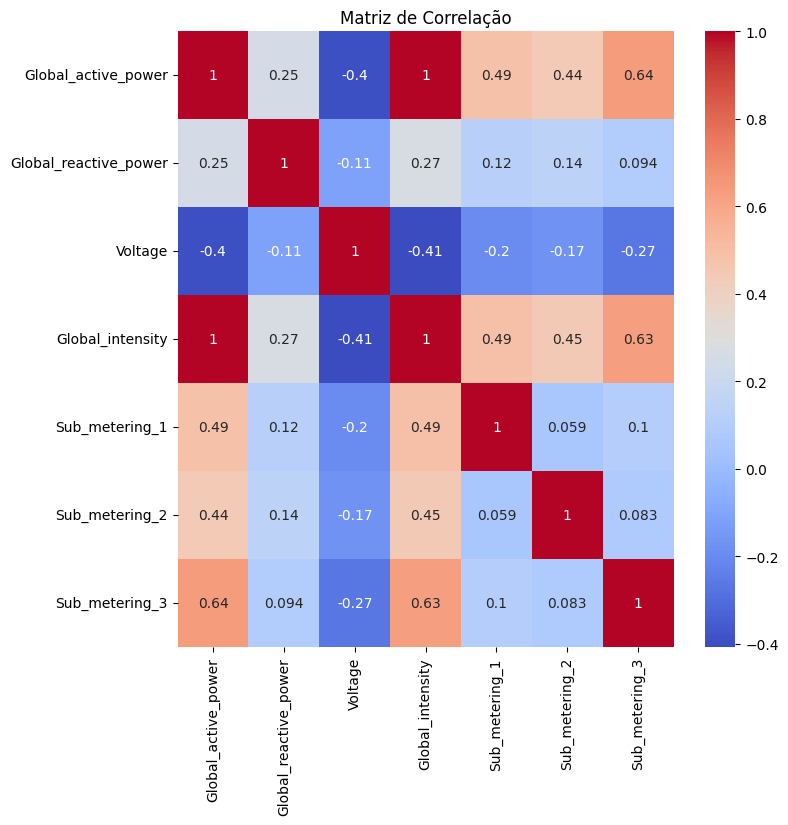

In [21]:
# escolhendo os atributos necessários para técnica de agrupamento

# Calcula a matriz de correlação
corr = df.corr()

# Plota a matriz de correlação como um heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

Neste momento, usamos as colunas abaixo pois a correlação delas são bem altas:
*   "Global_active_power";
*   "Voltage";
*   "Sub_metering_3"



In [22]:
df_cor = df[["Global_active_power", "Voltage","Sub_metering_3"]]

Abaixo vamos analisar a curva de Elbow para analiar a inércia, uma ferramenta muito importante para determinar o número ideal de clusters em um algoritmo de agrupamento (clustering), como o K-means.  


O gráfico sugere que o número ideal de clusters para este conjunto de dados é provavelmente 4.

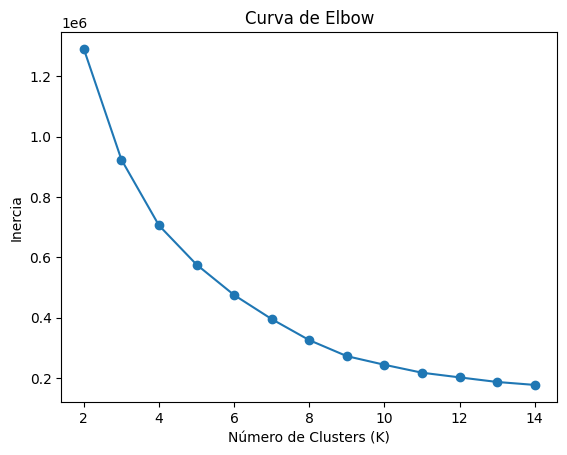

In [23]:
# Testando diferentes valores de K
inertia_values = []
valores_k = []

for k in range(2, 15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df_cor)
  inertia_values.append(kmeans.inertia_)
  valores_k.append(k)

# Plotando a curva de Elbow
plt.plot(valores_k, inertia_values, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Curva de Elbow')
plt.show()


Visualizar os cluster realizando gráficos de dispersão.

Abaixo iremos aplicar o algoritmo de K-Means com o número de cluster que foi indicado na curva de Elbow.

Após ser feita a aplicação, iremos visualizar os cluster com gráficos de dispersão e com isso, conseguimos chegar a algumas conclusões:

* O cluster roxo se caracteriza pelo baixo consumo de potência ativa média por minuto (Global_active_power) e também pelo baixo consumo de Sub_metering_3 porém varia amplamente o consumo de Voltage.

* O cluster verde ocupa uma faixa ampla de valores de Global_active_power, Voltage e Sub_metering_3. É o mais disperso entre os clusters, indicando que inclui uma variedade de padrões de consumo de energia.

* O cluster ciano se caracteriza por valores mais elevados de Sub_metering_3, e também tem um padrão parecido com o cluster verde,mas com uma concentração um pouco diferente em termos de Voltage e Sub_metering_3.

* O cluster amarelo possui valores de Voltage próximo a 240 que é um valor intermediário, em relação a Global_active_power, ele possui valores baixos, contendo alguns outliers. Por fim, em relação a Sub_metering_3 ele possui valores ligeiramente baixo, em torno de 0 a 5.

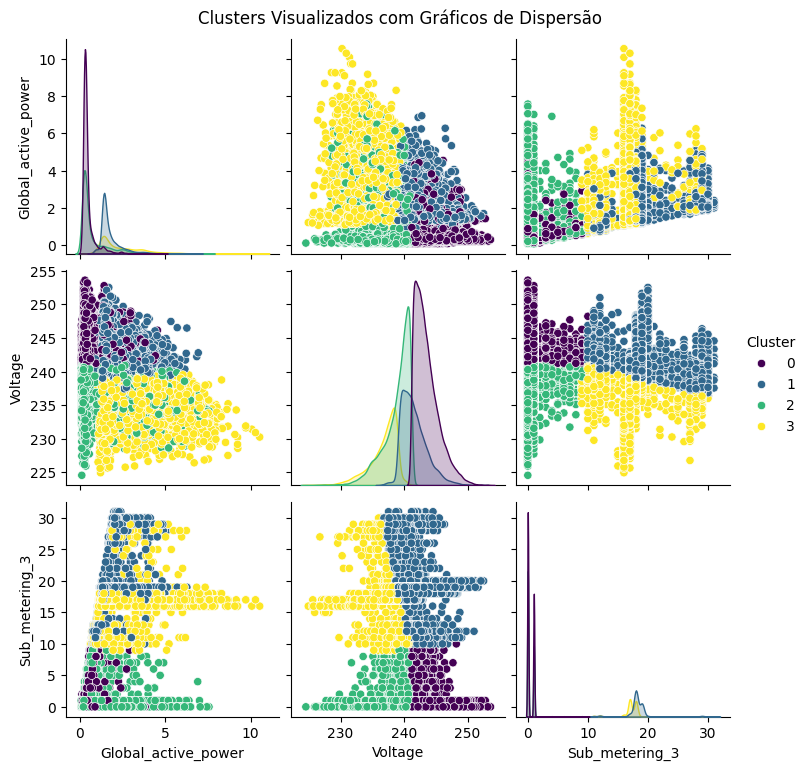

In [24]:
# Aplicando o algoritmo K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_cor)

# Obtendo os labels dos clusters
labels = kmeans.labels_

# Adicionando os labels ao DataFrame original
df_cor['Cluster'] = labels

# visualizando os clusters
sns.pairplot(df_cor, hue='Cluster', palette='viridis')
plt.suptitle('Clusters Visualizados com Gráficos de Dispersão', y=1.02)
plt.show()

## Analisando os dados com o dataframe reduzido

Agora vamos aplicar o K-Means no nosso dataframe que foi aplicado a técnica de PCA para redução das colunas e também vamos gerar um gráfico de dispersão, para poder fazer a comparação com nossos dados originais.

Primeiramente, vamos testar diferente valores de cluster e plotando a curva de Elbow usando a técnica de inercia para poder analisar qual a melhor quantidade de cluster.

Através do gráfico abaixo, conseguimos ver claramente que o número ideal de cluster permanece como 4

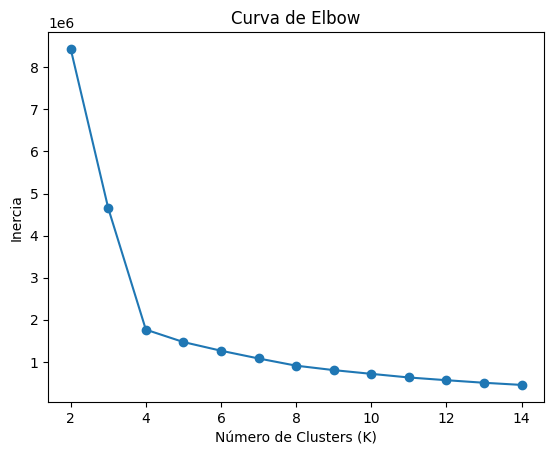

In [25]:
# Testando diferentes valores de K
inertia_values = []
valores_k = []
df_reduced = pd.DataFrame(df_reduced)

for k in range(2, 15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df_reduced)
  inertia_values.append(kmeans.inertia_)
  valores_k.append(k)

# Plotando a curva de Elbow
plt.plot(valores_k, inertia_values, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Curva de Elbow')
plt.show()

Agora vamos fazer um gráfico de dispersão com esses dados reduzidos, passando a mesma quantidade de cluster que passamos nos dados originais.

Conseguimos identificar alguns pontos:

*  Os clusters parecem estar razoavelmente bem separados, especialmente o cluster amarelo (3). Isso indica que o algoritmo de clusterização conseguiu identificar grupos distintos nos dados

* Alguns clusters, como o amarelo, são bem densos, com pontos agrupados próximos uns dos outros. Outros, como o roxo (0), são mais esparsos, indicando maior variabilidade interna

Podemos citar também alguns pontos individuais de cada cluster, como:

* Cluster roxo é menos populoso e parece ter uma distribuição mais espalhada

* Cluster azul apresenta algumas sobreposições com os cluster principalmente. Isso indica que pode ter algumas características semelhantes com os outros clusters

* Cluster verde possui alguns outliers

* Cluster amarelo é o mais numeroso e denso e entre os cluster esse é o que está mais razoavelmente separado]

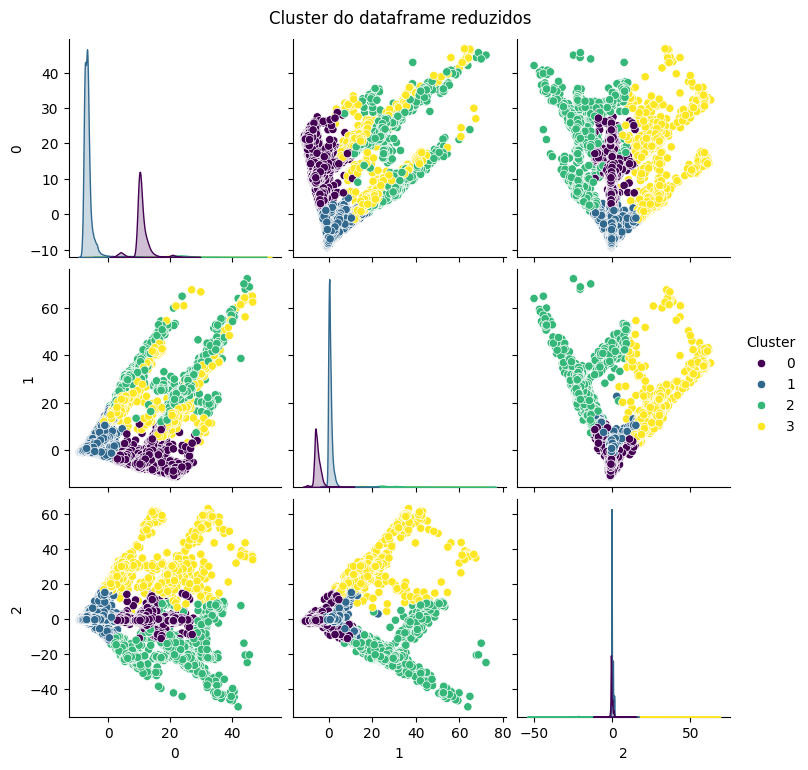

In [38]:
df_reduced = pd.DataFrame(df_reduced)

# Aplicando o algoritmo K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_reduced)

# Obtendo os labels dos clusters
labels = kmeans.labels_

# Adicionando os labels ao DataFrame original
df_reduced['Cluster'] = labels

# visualizando os clusters
sns.pairplot(df_reduced, hue='Cluster', palette='viridis')
plt.suptitle('Cluster do dataframe reduzido', y=1.02)
plt.show()

## Conclusão

Nessa segunda parte, analisamos a curva de Elbow e utilizamos a métrica de inercia para determinar o número ideal de cluster e com isso conseguimos definir que a quantidade ideal de cluster seria 4.

Após isso, fizemos gráficos de dispersão para entender os nossos clusters gerados através do K-Means e conseguimos observar que cada cluster tem caracterísitcas distintas entre eles.

Posteriomente, aplicamos a curva de Elbow utilizando também a métrica de inercia para o nosso dataset reduzido com o PCA e conseguimos confirmar que de fato, a quantidade ideal de cluster seria 4. A análise do cluster no nosso dataset reduzido mostrou padrões semelhantes aos clusters do dataset original, apresentando clusters densos, sobreposições e outliers.

# Conclusão final

Em nosso projeto, carregamos um dataframe que continha dados globais sobre consumo de energia.

Após fazer toda limpeza de dados, padronização e coletar 5% de amostra aleatória, aplicamos o algoritmo PCA para reduzir o número original dos atributos e conseguimos comprovar que, como as colunas do nosso dataset tem uma forte correlação, conseguimos uma explicação de variancia bem alta mesmo tendo reduzindo pela metade o número das colunas. E com isso conseguimos concluir o quão funcional é o algoritmo PCA para reduzir o volume de dados que serão treinados e o quanto ele é util para o nosso objetivo

Seguindo para próxima etapa, fizemos uma matriz de correlação e conseguimos confirmar o quanto os dados do nosso dataset tem uma alta correlação entre eles, dito isso, escolhemos 3 colunas para poder seguir com o nosso agrupamento, aplicamos o algoritmo de K-Means com diferente valores de número de clusters, levantando isso na curva de Elbow com a técnica de inércia, chegando a conclusão de que o número ideal de cluster seria 4 (tanto para o dataset original, quanto o reduzido). Para finalizar, aplicamos gráficos de dispersão para visualializar os clusters, e conseguimos encontrar padrões entre o dataset original e o reduzido com o PCA, assim como clusters densos, sobreposições e outliers.

Em suma, nosso projeto demonstrou a eficácia do PCA na redução da dimensionalidade de dados com alta correlação, otimizando o processo de treinamento sem comprometer a qualidade das informações. A análise subsequente com K-Means e a visualização dos clusters confirmaram a presença de padrões consistentes tanto nos dados originais quanto nos reduzidos, validando a utilidade do PCA em nosso contexto. A identificação de clusters densos, sobreposições e outliers enriquece nossa compreensão dos dados e abre caminho para análises mais aprofundadas e direcionadas

